# Analysis of dataset and results

In [536]:
import pandas as pd
import numpy as np
import pingouin as pg
import os
from glob import glob
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
#from statsmodels.stats.anova import AnovaRM
#from scipy import stats
from tqdm.auto import tqdm
import warnings

### Original/uncorrected results

In [4]:
def df_to_long(df, metric='PPPL'):
    df['seq_id'] = df.index
    df_long = df.melt(id_vars=['seq_id', 'person_word'], var_name='group')
    df_long.columns = ['Seq ID', 'Person word', 'Group', metric]
    return df_long

In [544]:
resultdir = '/srv/data/gussodato/thesis/results/'

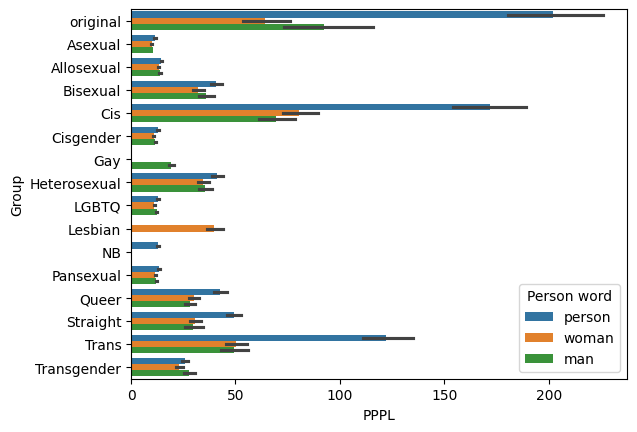

In [9]:
bert_example = pd.read_csv(glob(os.path.join(resultdir, 'bert-base*queerness.csv'))[0])
plot = sns.barplot(df_to_long(bert_example), x='PPPL', y='Group', hue='Person word')
plot.get_figure().savefig(os.path.join('./analysis_plots', 'bert_queerness_uncorrected_example'))

### Original sentence length

In [545]:
orig = pd.read_csv('/srv/data/gussodato/MARB/ententen/balanced_samples/race.csv')['original']
lengths = [len(sent.split()) for sent in orig]

In [157]:
sentlen = {'Sentence length': lengths}

/usr/local/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


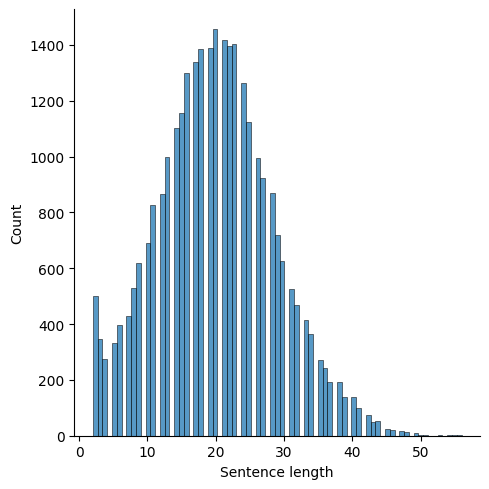

In [354]:
plot = sns.displot(sentlen, x='Sentence length')
plot.fig.savefig('./analysis_plots/sentence_length')

In [159]:
shortlen = {'Sentence length': [le for le in lengths if le<10]}

/usr/local/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


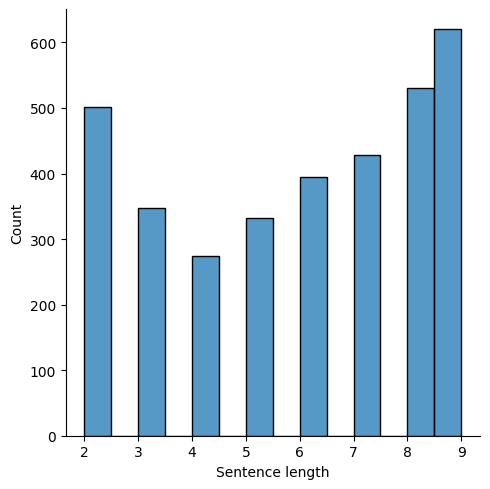

In [174]:
sns.displot(shortlen, x='Sentence length')

### Effect of minimum (tokenized) sequence length on result variability

In [537]:
from transformers import AutoTokenizer

In [540]:
def get_range(df, version='total'):
    if version == 'total':
        return df[df.columns[1:]].max().max()-df[df.columns[1:]].min().min()
    else:
        return df[df.columns[1:]].max()-df[df.columns[1:]].min()

In [538]:
def get_sd(df, version='total'):
    if version=='total':
        return df_to_long(df, metric='value')['value'].std(ddof=0)
    else:
        return df.std(ddof=0, numeric_only=True)

In [541]:
def variability_vs_minlen_cats(df, orig, tokenizer, varfunc=get_range, minvals=range(2,10)):
    results = {}
    for n in minvals:
        shorts = orig.loc[orig.apply(lambda x: len(tokenizer(x).input_ids[1:-1])<=n)].index
        newdf = df.drop(shorts)
        results[n] = varfunc(df, version='per_cat')
    return pd.DataFrame(results)

In [542]:
def variability_vs_minlen_cats_models(resultdir, orig, tokenizers, varfunc=get_sd, minvals=range(2,10,2)):
    results = {
        'disability': {model: {} for model in tokenizers},
        'queerness': {model: {} for model in tokenizers},
        'race': {model: {} for model in tokenizers},
        'total': {model: {} for model in tokenizers}
    }
    for model in tokenizers:
        print(f'Testing {model}...')
        lengths = pd.DataFrame([len(tokenizers[model](x).input_ids[1:-1]) for x in orig])
        files = glob(os.path.join(resultdir, model+'_*'))
        for n in tqdm(minvals):
            shorts = lengths[lengths[0]<=n].index
            total = pd.DataFrame()
            for file in files:
                info = os.path.basename(file).split('_')
                model, metric = info[:2]
                cat = info[-1][:-4]
                df = pd.read_csv(file).drop(shorts)
                if metric == 'PPPL':  # correct for error in PPPL-implementation
                    df[df.columns[1:]] = df[df.columns[1:]]/2
                results[cat][model][n] = varfunc(df)
                for col in df.columns:
                    total[col] = df[col]
            results['total'][model][n] = varfunc(total)
    return results

In [543]:
tokenizers = {'bert-base-uncased': AutoTokenizer.from_pretrained('bert-base-uncased'),
 'bert-large-uncased': AutoTokenizer.from_pretrained('bert-large-uncased'), 
 'albert-base-v2': AutoTokenizer.from_pretrained('albert/albert-base-v2'), 
 'albert-large-v2': AutoTokenizer.from_pretrained('albert/albert-large-v2'), 
 'roberta-base': AutoTokenizer.from_pretrained('FacebookAI/roberta-base'),
 'roberta-large': AutoTokenizer.from_pretrained('FacebookAI/roberta-large'), 
 'gpt2': AutoTokenizer.from_pretrained('openai-community/gpt2'), 
 'gpt2-medium': AutoTokenizer.from_pretrained('openai-community/gpt2-medium'),
 'opt-350m': AutoTokenizer.from_pretrained('facebook/opt-350m'), 
 'bloom-560m': AutoTokenizer.from_pretrained('bigscience/bloom-560m')
             }

In [546]:
std_dict0 = variability_vs_minlen_cats_models(resultdir, orig, tokenizers, minvals=range(0,10,2))

Testing bert-base-uncased...


  0%|          | 0/5 [00:00<?, ?it/s]

Testing bert-large-uncased...


  0%|          | 0/5 [00:00<?, ?it/s]

Testing albert-base-v2...


  0%|          | 0/5 [00:00<?, ?it/s]

Testing albert-large-v2...


  0%|          | 0/5 [00:00<?, ?it/s]

Testing roberta-base...


  0%|          | 0/5 [00:00<?, ?it/s]

Testing roberta-large...


  0%|          | 0/5 [00:00<?, ?it/s]

Testing gpt2...


  0%|          | 0/5 [00:00<?, ?it/s]

Testing gpt2-medium...


  0%|          | 0/5 [00:00<?, ?it/s]

Testing opt-350m...


  0%|          | 0/5 [00:00<?, ?it/s]

Testing bloom-560m...


  0%|          | 0/5 [00:00<?, ?it/s]

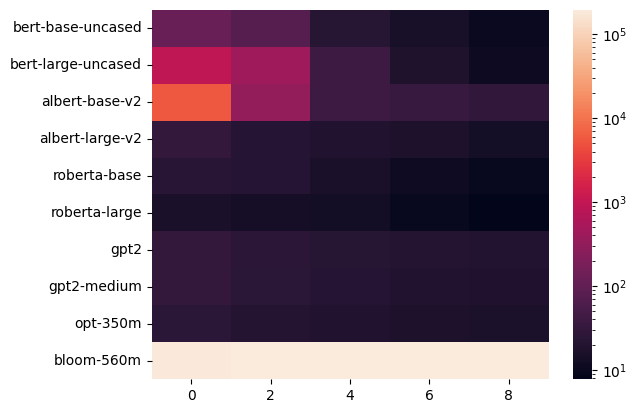

In [379]:
plot = sns.heatmap(pd.DataFrame(std_dict0['total']).transpose(), norm=LogNorm())

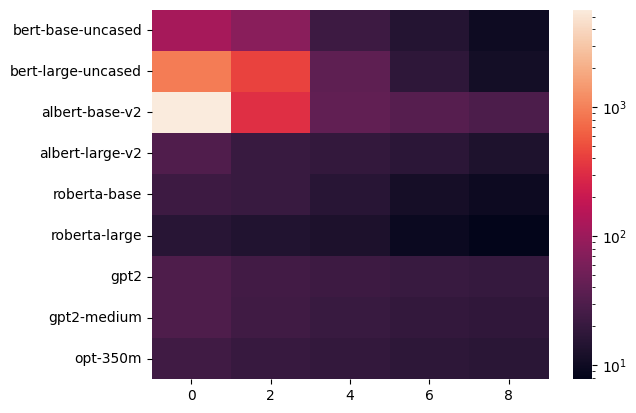

In [380]:
plot = sns.heatmap(pd.DataFrame(std_dict0['total']).transpose().drop('bloom-560m'), norm=LogNorm())

In [387]:
for cat in std_dict0:
    plot = sns.heatmap(pd.DataFrame(std_dict[cat]).transpose().drop('bloom-560m'), norm=LogNorm())
    plot.get_figure().savefig(os.path.join('./analysis_plots', '_'.join(['heatmap', 'minlen-vs-std', cat])))
    plot.get_figure().clf()

<Figure size 640x480 with 0 Axes>

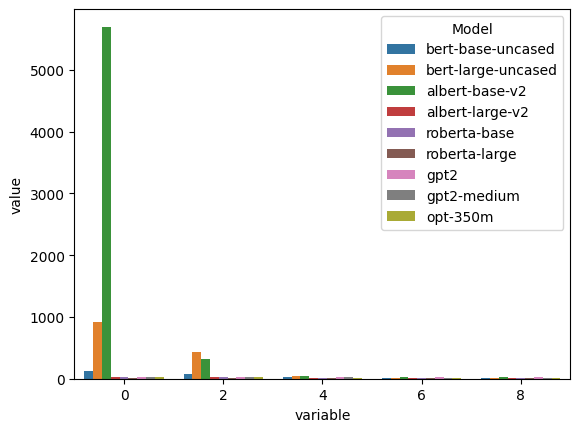

In [547]:
df = pd.DataFrame(std_dict0['total']).transpose().drop('bloom-560m')
df['Model'] = df.index
melted = df.melt(id_vars='Model')
plot = sns.barplot(melted, x='variable', y='value', hue='Model')

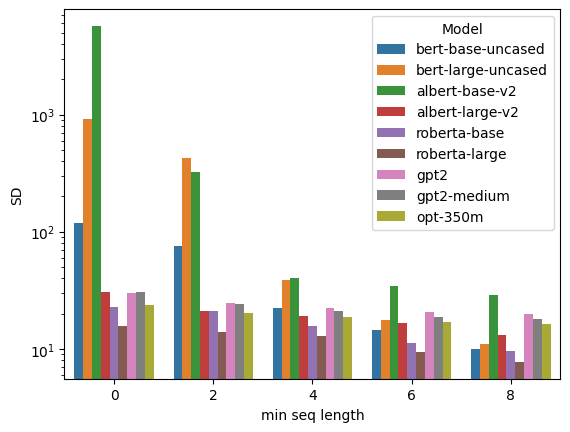

In [550]:
df = pd.DataFrame(std_dict0['total']).transpose().drop('bloom-560m')
df['Model'] = df.index
melted = df.melt(id_vars='Model', value_name='SD', var_name='min seq length')
plot = sns.barplot(melted, x='min seq length', y='SD', hue='Model')
plt.yscale('log')

In [552]:
for cat in std_dict0:
    df = pd.DataFrame(std_dict0[cat]).transpose().drop('bloom-560m')
    df['Model'] = df.index
    melted = df.melt(id_vars='Model', value_name='SD', var_name='min seq length')
    plot = sns.barplot(melted, x='min seq length', y='SD', hue='Model')
    plt.yscale('log')
    plot.get_figure().savefig(os.path.join('./analysis_plots', '_'.join(['barplot', 'minlen-vs-std', cat])))
    plot.get_figure().clf()

<Figure size 640x480 with 0 Axes>

Interesting, BLOOM has exactly the opposite behavior. 

<Axes: >

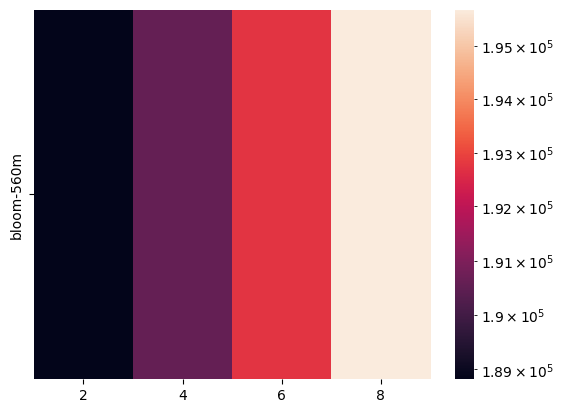

In [344]:
sns.heatmap(pd.DataFrame(std_dict['total']).transpose().loc[['bloom-560m']], norm=LogNorm())

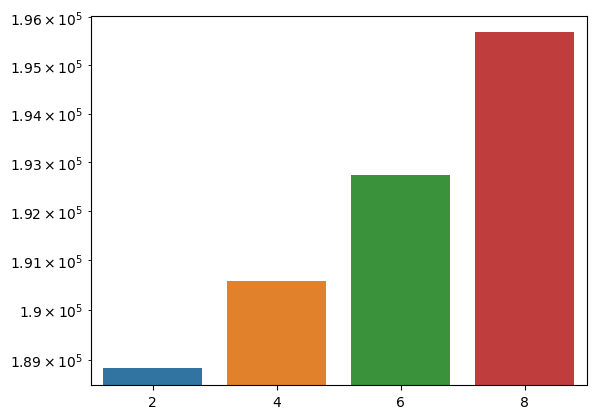

In [378]:
sns.barplot(pd.DataFrame(std_dict['total']).transpose().loc[['bloom-560m']])
plt.yscale('log')

### Model vocabularies

In [86]:
terms = {'disability': ['deaf',
                'blind',
                'with a disability',
                'in a wheelchair',
                'with cerebral palsy',
                'with a mental illness',
                'with epilepsy',
                'with spinal curvature',
                'chronically ill',
                'short-statured',
                'with dyslexia',
                'with Down’s syndrome',
                'without a disability'],
 'race': ['native american',
          'asian',
          'black',
          'hispanic',
          'pacific islander',
          'white'],
 'queerness': ['asexual',
               'allosexual',
               'bisexual',
               'cis',
               'cisgender',
               'gay',
               'heterosexual',
               'LGBTQ',
               'lesbian',
               'nonbinary',
               'pansexual',
               'queer',
               'straight',
               'trans',
               'transgender']}

In [89]:
index = pd.MultiIndex.from_tuples([(cat,term) for cat in terms for term in terms[cat]])

In [102]:
in_model_vocab = {}
for model, tokenizer in tokenizers.items():
    in_model_vocab[model] = []
    for cat, expression in index:
        in_model_vocab[model].append(not (tokenizer.unk_token_id in tokenizer.convert_tokens_to_ids(expression.split())))

In [105]:
in_vocab_df = pd.DataFrame(in_model_vocab, index=index)
in_vocab_df

bert-base-uncased  bert-large-uncased  \
disability deaf                                True                True   
           blind                               True                True   
           with a disability                   True                True   
           in a wheelchair                     True                True   
           with cerebral palsy                False               False   
           with a mental illness               True                True   
           with epilepsy                      False               False   
           with spinal curvature               True                True   
           chronically ill                    False               False   
           short-statured                     False               False   
           with dyslexia                      False               False   
           with Down’s syndrome               False               False   
           without a disability                True                True   
race       native american                     True                True   
           asian                               True                True   
           black                               True                True   
           hispanic                            True                True   
           pacific islander                    True                True   
           white                               True                True   
queerness  asexual                            False               False   
           allosexual                         False               False   
           bisexual                            True                True   
           cis                                 True                True   
           cisgender                          False               False   
           gay                                 True                True   
           heterosexual                        True                True   
           LGBTQ                              False               False   
           lesbian                             True                True   
           nonbinary                          False               False   
           pansexual                          False               False   
           queer                               True                True   
           straight                            True                True   
           trans                               True                True   
           transgender                         True                True   

                                  albert-base-v2  albert-large-v2  \
disability deaf                            False            False   
           blind                            True             True   
           with a disability               False            False   
           in a wheelchair                 False            False   
           with cerebral palsy             False            False   
           with a mental illness           False            False   
           with epilepsy                   False            False   
           with spinal curvature           False            False   
           chronically ill                 False            False   
           short-statured                  False            False   
           with dyslexia                   False            False   
           with Down’s syndrome            False            False   
           without a disability            False            False   
race       native american                  True             True   
           asian                           False            False   
           black                            True             True   
           hispanic                         True             True   
           pacific islander                False            False   
           white                            True             True   
queerness  asexual          

In [112]:
n_tokens = {}
for model, tokenizer in tokenizers.items():
    n_tokens[model] = []
    for cat, expression in index:
        n_tokens[model].append(len(tokenizer(expression, add_special_tokens=False).input_ids))

In [114]:
n_tokens_df = pd.DataFrame(n_tokens, index=index)
n_tokens_df

bert-base-uncased  bert-large-uncased  \
disability deaf                                   1                   1   
           blind                                  1                   1   
           with a disability                      3                   3   
           in a wheelchair                        3                   3   
           with cerebral palsy                    4                   4   
           with a mental illness                  4                   4   
           with epilepsy                          4                   4   
           with spinal curvature                  3                   3   
           chronically ill                        3                   3   
           short-statured                         4                   4   
           with dyslexia                          5                   5   
           with Down’s syndrome                   5                   5   
           without a disability                   3                   3   
race       native american                        2                   2   
           asian                                  1                   1   
           black                                  1                   1   
           hispanic                               1                   1   
           pacific islander                       2                   2   
           white                                  1                   1   
queerness  asexual                                3                   3   
           allosexual                             4                   4   
           bisexual                               1                   1   
           cis                                    1                   1   
           cisgender                              3                   3   
           gay                                    1                   1   
           heterosexual                           1                   1   
           LGBTQ                                  2                   2   
           lesbian                                1                   1   
           nonbinary                              3                   3   
           pansexual                              4                   4   
           queer                                  1                   1   
           straight                               1                   1   
           trans                                  1                   1   
           transgender                            1                   1   

                                  albert-base-v2  albert-large-v2  \
disability deaf                                1                1   
           blind                               1                1   
           with a disability                   3                3   
           in a wheelchair                     3                3   
           with cerebral palsy                 4                4   
           with a mental illness               4                4   
           with epilepsy                       2                2   
           with spinal curvature               3                3   
           chronically ill                     3                3   
           short-statured                      5                5   
           with dyslexia                       4                4   
           with Down’s syndrome                5                5   
           without a disability                3                3   
race       native american                     2                2   
           asian                               1                1   
           black                               1                1   
           hispanic                            1                1   
           pacific islander                    2                2   
           white                               1                1   
queerness  asexual          

In [ ]:
#cmap=sns.diverging_palette(30, 250, l=65, as_cmap=True)

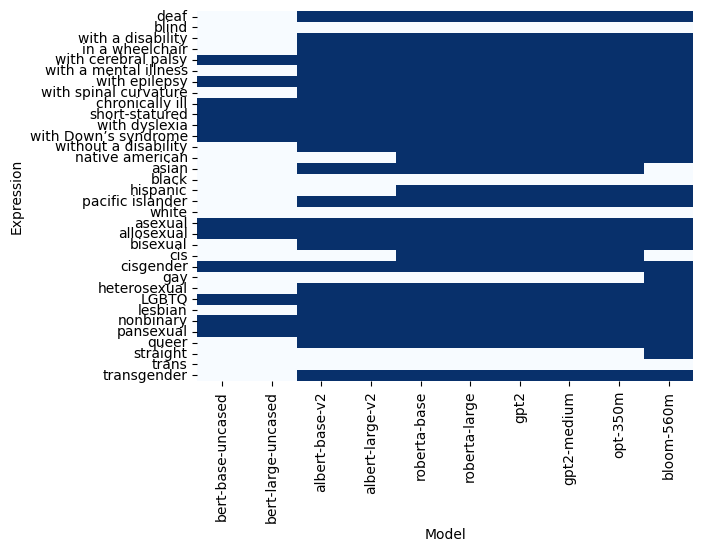

In [271]:
plot = sns.heatmap(in_vocab_df, yticklabels=[i[1] for i in n_tokens_df.index], cmap=sns.color_palette('Blues_r', as_cmap=True), cbar=False)
plt.ylabel('Expression')
plt.xlabel('Model')
plot.get_figure().savefig('./analysis_plots/heatmap_expression-in-model-vocab')

In [272]:
plot.get_figure().clf()

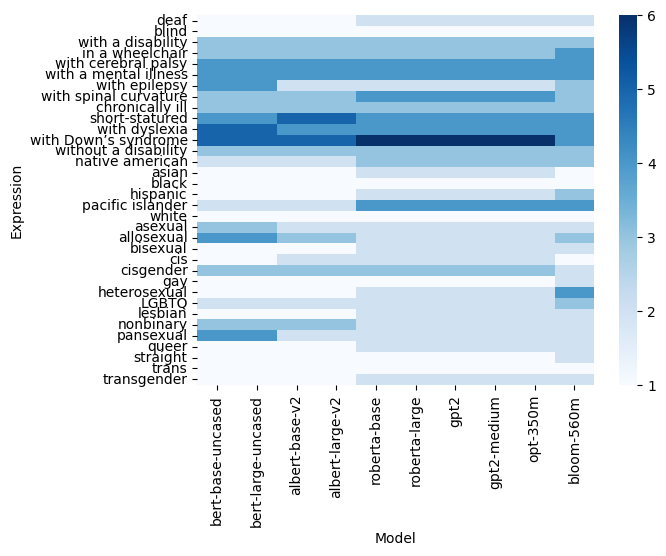

In [273]:
plot = sns.heatmap(n_tokens_df, cmap='Blues', yticklabels=[i[1] for i in n_tokens_df.index])
plt.ylabel('Expression')
plt.xlabel('Model')
plot.get_figure().savefig('./analysis_plots/heatmap_n-tokens-per-expression')

In [274]:
plot.get_figure().clf()

### Effect on results
#### Example: BERT

In [211]:
import ipyplot

In [200]:
bert_disability, bert_race, bert_queerness = [pd.read_csv(file) for file in glob(os.path.join(resultdir, 'bert-base*'))]

In [492]:
def plotgrid(df_disability, df_race, df_queerness, correction='no corrections', model='bert', img_width=350, xlim=250):
    plots = []
    for data, title in zip([df_disability, df_race, df_queerness], ['disability', 'race', 'queerness']):
        long = df_to_long(data)
        plot = sns.barplot(df_to_long(data), x='PPPL', y='Group', hue='Person word')
        plot.set(title=f'BERT {title}, {correction}', xlim=(0,xlim))
        path = os.path.join('./analysis_plots', '_'.join([model, '-'.join(correction.split()), title]))
        plot.get_figure().savefig(path)
        plots.append(path)
        plot.get_figure().clf()
    ipyplot.plot_images([plot+'.png' for plot in plots], img_width=img_width)

#### No corrections:

In [246]:
plotgrid(bert_disability, bert_race, bert_queerness)

<Figure size 640x480 with 0 Axes>

#### Remove shorts (tokenized sequence length <= 4):

In [241]:
tokenizer = tokenizers['bert-base-uncased']
n=4
orig = pd.read_csv('/srv/data/gussodato/MARB/ententen/balanced_samples/race.csv')['original']
shorts = orig.loc[orig.apply(lambda x: len(tokenizer(x).input_ids[1:-1])<=n)].index

In [248]:
plotgrid(bert_disability.drop(shorts), bert_race.drop(shorts), bert_queerness.drop(shorts), correction='more than 4 tokens', xlim=40)

<Figure size 640x480 with 0 Axes>

#### Remove words that are not in vocab (as single tokens):

In [258]:
def remove_oov(df, cat):
    combos = list(zip(terms[cat], df.columns[2:]))
    new_df = df.copy()
    for expression, group in combos:
        if tokenizer.unk_token_id in tokenizer.convert_tokens_to_ids(expression.split()):
            new_df = new_df.drop(columns=group)
    return new_df

In [259]:
plotgrid(remove_oov(bert_disability, 'disability'), remove_oov(bert_race, 'race'), remove_oov(bert_queerness, 'queerness'), correction='remove out of vocab tokens')


<Figure size 640x480 with 0 Axes>

In [263]:
plotgrid(remove_oov(bert_disability.drop(shorts), 'disability'), remove_oov(bert_race.drop(shorts), 'race'), remove_oov(bert_queerness.drop(shorts), 'queerness'), correction='more than 4 tokens+remove oov', xlim=40)


<Figure size 640x480 with 0 Axes>

However, this method is not applicable to all models since they may use subword tokens for most words.

Also, case is a problem. The dataset was designed with uncased models in mind, and that produced some high perplexities for tokens like "american", "asian" in cased models. 

### Wilcoxon etc

In [276]:
import pingouin as pg

In [328]:
def wilcoxon_df(df):
    original = df['original']
    result = {}
    for col in df.columns[2:]:
        difference = df[col]-original
        res = pg.wilcoxon(difference).iloc[0]
        result[col] = str(round(res['RBC'], 2)) + '*' if res['p-val']<0.05 else str(round(res['RBC'], 2))
        #result[col] = pg.wilcoxon(df[col], original)  ## MUCH slower, and result is the same (except CLES missing from first alternative)
    return result

In [357]:
def test_all_files(resultdir):
    results = {'disability': pd.DataFrame(), 'race': pd.DataFrame(), 'queerness': pd.DataFrame()}
    for file in os.listdir(resultdir):
        info = file.split('_')
        model = info[0]
        category = info[-1][:-4]
        df = pd.read_csv(os.path.join(resultdir, file))
        results[category][model] = wilcoxon_df(df)
    return results

In [426]:
orig = pd.read_csv('/srv/data/gussodato/MARB/ententen/balanced_samples/race.csv')['original']

In [434]:
def test_all_files_personwords(resultdir, models, original=None, minlen=None):
    person_words = ['person', 'woman', 'man', 'total']
    columns = pd.MultiIndex.from_product([models, person_words], names=['model', 'person word'])
    results = {'disability': pd.DataFrame(columns=columns), 'race': pd.DataFrame(columns=columns), 'queerness': pd.DataFrame(columns=columns)}
    shorts = []
    if minlen:
        shorts = original.loc[original.apply(lambda x: len(x.split())<=minlen)].index
        print(f'Dropping {len(shorts)} examples of less than {minlen} words.')
    for file in tqdm(os.listdir(resultdir)):
        info = file.split('_')
        model = info[0]
        category = info[-1][:-4]    
        df = pd.read_csv(os.path.join(resultdir, file)).drop(shorts)
        with warnings.catch_warnings():  # bc pengouin complains that it cannot calculate CLES for single set of differences
            warnings.simplefilter("ignore")
            for word in person_words[:-1]:
                subset = df[df['person_word'] == word]
                results[category][(model, word)] = wilcoxon_df(subset)
            results[category][(model, 'total')] = wilcoxon_df(df)
    return results

In [404]:
results = test_all_files_personwords(resultdir, tokenizers.keys())

  0%|          | 0/30 [00:00<?, ?it/s]

In [431]:
results['race']

model            bert-base-uncased                         bert-large-uncased  \
person word                 person   woman     man   total             person   
native_american             -0.31*  -0.65*  -0.21*  -0.39*             -0.12*   
asian                        0.74*    0.6*    0.8*   0.73*              0.76*   
black                        0.65*   0.62*   0.64*   0.64*              0.66*   
hispanic                     0.81*   0.82*   0.88*   0.84*              0.87*   
pacific_islander            -0.25*     0.0    0.4*   0.05*             -0.45*   
white                        0.64*   0.59*   0.58*   0.61*              0.65*   

model                                    albert-base-v2          ...  \
person word        woman     man   total         person   woman  ...   
native_american   -0.48*  -0.03*  -0.21*         -0.17*  -0.59*  ...   
asian              0.67*   0.82*   0.75*          0.73*   0.45*  ...   
black              0.63*   0.62*   0.64*          0.79*   0.49*  ...   
hispanic           0.92*   0.95*   0.92*          0.89*    0.7*  ...   
pacific_islander  -0.49*  -0.05*  -0.34*          0.63*   0.35*  ...   
white              0.63*   0.62*   0.64*          0.83*    0.5*  ...   

model            gpt2-medium        opt-350m                          \
person word              man  total   person   woman     man   total   
native_american        0.29*  0.28*   -0.13*  -0.63*  -0.42*  -0.39*   
asian                  0.71*  0.68*     0.5*  -0.21*   0.13*   0.17*   
black                  0.54*  0.58*    0.62*   0.26*   0.32*   0.43*   
hispanic               0.76*  0.73*     0.5*   0.17*   0.48*    0.4*   
pacific_islander       0.83*  0.82*    0.59*   0.35*   0.35*   0.44*   
white                  0.62*  0.62*    0.68*    0.5*   0.57*   0.59*   

model            bloom-560m                        
person word          person   woman    man  total  
native_american       0.61*  -0.06*  0.28*  0.29*  
asian                 0.79*    0.2*  0.59*  0.56*  
black                 0.83*   0.54*  0.61*  0.69*  
hispanic              0.88*    0.8*  0.89*  0.86*  
pacific_islander      0.87*   0.83*  0.89*  0.86*  
white                 0.85*   0.56*  0.64*  0.71*  

[6 rows x 40 columns]

In [424]:
for cat in results:
    results[cat].to_csv('./tables/'+cat+'_results.csv')

In [425]:
pd.read_csv('./tables/race_results.csv', header=[0,1], index_col=0)

model            bert-base-uncased                         bert-large-uncased  \
person word                 person   woman     man   total             person   
native_american             -0.31*  -0.65*  -0.21*  -0.39*             -0.12*   
asian                        0.74*    0.6*    0.8*   0.73*              0.76*   
black                        0.65*   0.62*   0.64*   0.64*              0.66*   
hispanic                     0.81*   0.82*   0.88*   0.84*              0.87*   
pacific_islander            -0.25*     0.0    0.4*   0.05*             -0.45*   
white                        0.64*   0.59*   0.58*   0.61*              0.65*   

model                                    albert-base-v2          ...  \
person word        woman     man   total         person   woman  ...   
native_american   -0.48*  -0.03*  -0.21*         -0.17*  -0.59*  ...   
asian              0.67*   0.82*   0.75*          0.73*   0.45*  ...   
black              0.63*   0.62*   0.64*          0.79*   0.49*  ...   
hispanic           0.92*   0.95*   0.92*          0.89*    0.7*  ...   
pacific_islander  -0.49*  -0.05*  -0.34*          0.63*   0.35*  ...   
white              0.63*   0.62*   0.64*          0.83*    0.5*  ...   

model            gpt2-medium        opt-350m                          \
person word              man  total   person   woman     man   total   
native_american        0.29*  0.28*   -0.13*  -0.63*  -0.42*  -0.39*   
asian                  0.71*  0.68*     0.5*  -0.21*   0.13*   0.17*   
black                  0.54*  0.58*    0.62*   0.26*   0.32*   0.43*   
hispanic               0.76*  0.73*     0.5*   0.17*   0.48*    0.4*   
pacific_islander       0.83*  0.82*    0.59*   0.35*   0.35*   0.44*   
white                  0.62*  0.62*    0.68*    0.5*   0.57*   0.59*   

model            bloom-560m                        
person word          person   woman    man  total  
native_american       0.61*  -0.06*  0.28*  0.29*  
asian                 0.79*    0.2*  0.59*  0.56*  
black                 0.83*   0.54*  0.61*  0.69*  
hispanic              0.88*    0.8*  0.89*  0.86*  
pacific_islander      0.87*   0.83*  0.89*  0.86*  
white                 0.85*   0.56*  0.64*  0.71*  

[6 rows x 40 columns]

In [435]:
results_min_4 = test_all_files_personwords(resultdir, tokenizers.keys(), original=orig, minlen=4)

Dropping 1122 examples of less than 4 words.


  0%|          | 0/30 [00:00<?, ?it/s]

In [495]:
#print(results_min_4['race'].to_latex())  # way too big table

In [437]:
for cat in results_min_4:
    results_min_4[cat].to_csv('./tables/'+cat+'_results_exclude-shorts<4.csv')

In [464]:
test = pd.read_csv('./tables/race_results_exclude-shorts<4.csv', header=[0,1], index_col=0)

/tmp/ipykernel_3411394/2627755331.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['group'] = subset.index
/tmp/ipykernel_3411394/2627755331.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['value'] = [float(x.strip('*')) for x in subset['value']]


[(-1.0, 1.0)]

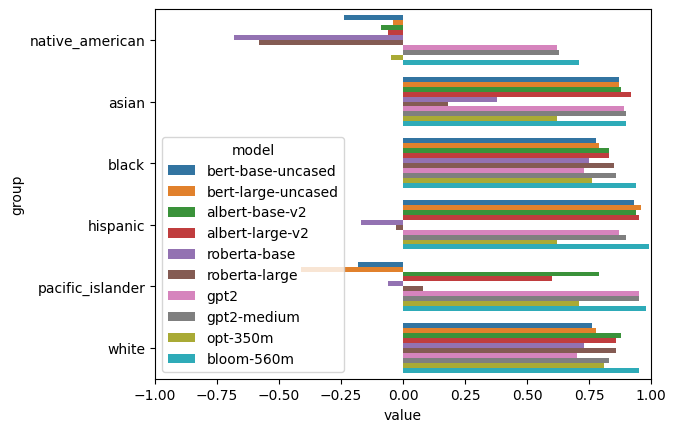

In [523]:
testlong = test.melt(ignore_index=False)
subset = testlong[testlong['person word'] == 'person']
subset['group'] = subset.index
subset['value'] = [float(x.strip('*')) for x in subset['value']]
plot = sns.barplot(subset, y='group', x='value', hue='model')
plot.set(xlim=(-1,1))

[(-1.0, 1.0)]

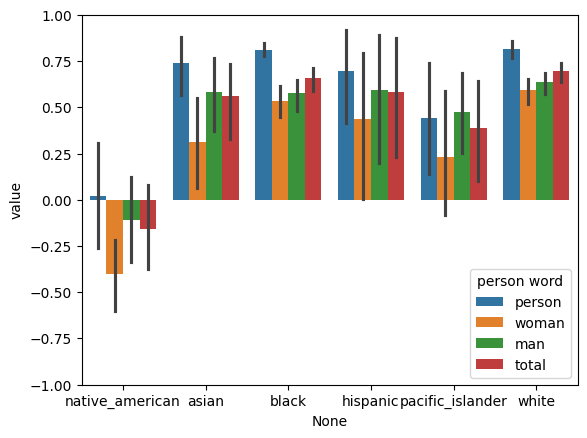

In [490]:
testlong = test.melt(ignore_index=False)
testlong['value'] = [float(x.strip('*')) for x in testlong['value']]
plot = sns.barplot(testlong, x=testlong.index, y='value', hue='person word')
plot.set(ylim=(-1,1))

In [534]:
def plot_wilcoxon_results(files, img_width=350, xlim=(-1,1)):
    plots = []
    for file in files:
        category = os.path.basename(file).split('_')[0]
        df = pd.read_csv(file, header=[0,1], index_col=0)
        long = df.melt(ignore_index=False)
        long['value'] = [float(str(x).strip('*')) for x in long['value']]
        for word in ['person','woman','man','total']:
            subset = long[long['person word'] == word].copy() 
            subset['group'] = subset.index
            subset = subset.reset_index(drop=True)
            plot = sns.barplot(subset, x='value', y='group', hue='model')
            plot.set(title=f'Wilcoxon results, {category}, {word}', xlim=xlim)
            path = './analysis_plots/wilcoxon_'+'_'.join([category, word])
            plot.get_figure().savefig(path)
            plots.append(path)
            plot.get_figure().clf()
    ipyplot.plot_images([plot+'.png' for plot in plots], img_width=img_width)


# separate mlms and autoregressive? or some other way?

In [533]:
plot_wilcoxon_results(glob('./tables/*4.csv'))

<Figure size 640x480 with 0 Axes>

Ok this is completely unreadable...